
# Look at association of genetic status @ session 1 B
Changes to previous version:
- do marginal FDR correction
- put swarmplots on the boxplots
- have only one plot per subtype

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import nilearn as nil
import seaborn as sns
import nibabel as nib
from scipy import io as sio
import statsmodels.api as sm
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from statsmodels.sandbox.stats import multicomp as smi

In [67]:
# Paths
model_path = '/data1/guillimin/sim_data/simons_vip/pheno/dataset_16p_session1.csv'
weights_path = '/data1/guillimin/sim_data/simons_vip/subtype/subtypes3_16p_session1/subtype_weights.mat'
sbt_map_temp= '/data1/guillimin/sim_data/simons_vip/subtype/subtypes3_16p_session1/network_{}/mean_subtype.nii.gz'

In [6]:
model = pd.read_csv(model_path, delimiter=',')

In [7]:
tmp = sio.loadmat(weights_path)
weights = tmp['weight_mat']

In [8]:
n_sbt, n_net = weights.shape[1:]

In [9]:
p_mat = np.zeros((n_sbt, n_net))
res_list = list()
for nid in range(n_net):
    tmp_list = list()
    for sid in range(n_sbt):
        m = sm.OLS(weights[:, sid, nid], model[['g1','g2','g3']])
        res = m.fit()
        p_mat[sid, nid] = res.f_pvalue
        tmp_list.append(res)
    res_list.append(tmp_list)

In [10]:
pcorr_vec = smi.multipletests(p_mat.flatten(), alpha=0.05, method='fdr_bh')
pcorr_mat = np.reshape(pcorr_vec[0], (n_sbt, n_net))

In [11]:
pcorr_mat

array([[False, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False,  True, False, False,
        False, False, False],
       [False, False, False, False, False, False,  True, False, False,
        False,  True, False]], dtype=bool)

In [12]:
# Run post hoc tests on the subtypes that show effects
hits = np.argwhere(pcorr_mat)
n_hits = len(hits)

In [13]:
# Sort hits by network
ind = np.argsort([x[1] for x in hits])
hits = hits[ind]

In [33]:
# Define the post hocs to run
post_hocs = 'g1 = g2, g2 = g3, g1 = g3'
post_dict = {0:'g1vg2', 1:'g2vg3', 2:'g1vg3'}
hit_dict = dict()

#for hit_sbt, hit_net in hits:
for hit_sbt, hit_net in hits:
    if not hit_net in hit_dict.keys():
        hit_dict[hit_net] = dict()
    res = res_list[hit_net][hit_sbt]
    pvals = res.t_test(post_hocs).pvalue
    # FDR
    corr = smi.multipletests(pvals, alpha=0.05, method='fdr_bh')
    # Store
    hit_dict[hit_net][hit_sbt] = corr

- G1 - Dels (Autism)
- G2 - Controls
- G3 - Dups (Schizo)

<IPython.core.display.Javascript object>


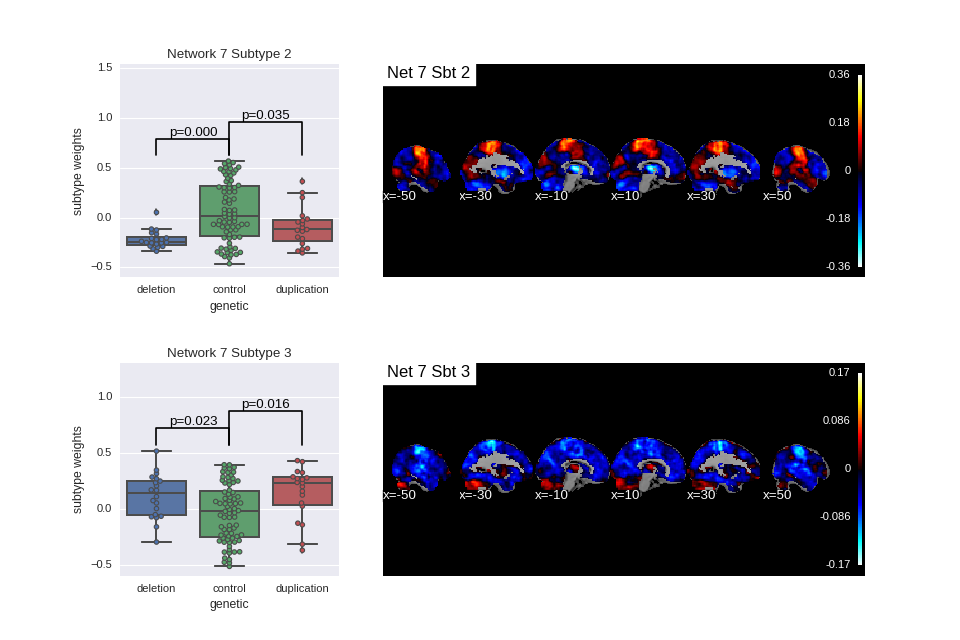

<IPython.core.display.Javascript object>


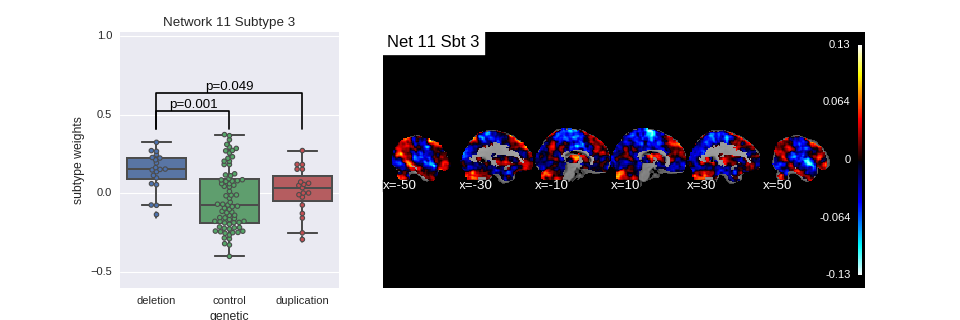

In [98]:
for net in sorted(hit_dict.keys()):
    tmpd = hit_dict[net]
    n_plots = len(tmpd.keys())
    # Prepare figure
    fig = plt.figure(figsize=(12,4*n_plots))
    gs = gridspec.GridSpec(n_plots, 3, hspace=0.4)
    
    for pid, sbt in enumerate(sorted(tmpd.keys())):
        # Define axis
        ax = fig.add_subplot(gs[pid,0])
        fd_pass, pval, a, b = tmpd[sbt]
        n_tests = np.sum(fd_pass)
        
        # Plot the main plot
        sns.boxplot(model.genetic, weights[:, sbt, net], ax=ax)
        # Add swarm plot
        sns.boxplot(model.genetic, weights[:, sbt, net], ax=ax)
        sns.swarmplot(model.genetic, weights[:, sbt, net], ax=ax, size=4, linewidth=1)
        # Compute text overlay
        y = weights[:, sbt, net].max()
        h = y*0.15*n_tests
        y += y*0.1
        
        # Go through the significant tests
        for tid, test in enumerate(np.argwhere(fd_pass)):
            # figure out the test
            if test[0] == 0:
                x1, x2 = 0, 1
            elif test[0] == 1:
                x1, x2 = 1, 2
            elif test[0] == 2:
                x1, x2 = 0, 2
            
            ax.plot([x1, x1, x2, x2], [y, y+h*(tid+1), y+h*(tid+1), y], lw=1.5, c='k')
            ax.text((x1+x2)*.5, y+h*(tid+1), 'p={:.3f}'.format(pval[test][0]), ha='center', va='bottom', color='k')
            
        # Set axis
        (dn, up) = ax.get_ylim()
        ax.set_ylim((dn, up+h*n_tests))
        #ax.set_ylim((-0.8, 1.3))
        ax.set_title('Network {} Subtype {}'.format(net+1, sbt+1))
        ax.set_xticklabels(['deletion', 'control', 'duplication'])
        ax.set_ylabel('subtype weights')
        
        # Add the network plot
        ax2 = fig.add_subplot(gs[pid,1:])
        tmp_i = nib.load(sbt_map_temp.format(net+1))
        # Load the corresponding network
        nlp.plot_stat_map(nil.image.index_img(tmp_i, sbt), display_mode='x', threshold=0, 
                          cut_coords=[-50, -30, -10, 10, 30, 50], black_bg=True,axes=ax2,
                          title='Net {} Sbt {}'.format(net+1, sbt+1))